In [177]:
#Импортируем библиотеки, если не хватает чего-то, надо доустановить  (pip install или conda )
import numpy as np 
import os
import pandas as pd 
import datetime
import drms
import urllib
from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
import urllib, requests
import matplotlib.pyplot as plt
from sunpy.coordinates import frames
import warnings
warnings.filterwarnings("ignore")
import sunpy.wcs
import sunpy.map
import pickle
import re
import matplotlib.patches as patches
import logging
from tg_tqdm import tg_tqdm
%matplotlib inline

In [2]:
EMAIL = 'iknyazeva@gmail.com'
SAVE_PATH = 'MDIdataset'
tg_token = '831964163:AAH7SoaoqWzWIcHaS3yfdmMu-H46hhtUaXw'
tg_chat_id = 1147194
ik_chat_id = 94616973
sun_group_id = -321681009


def check_dataset_directory():
    if not os.path.exists('MDIdataset/fragments'):
        os.makedirs('MDIdataset/fragments')
    
    return 'MDIdataset'
check_dataset_directory()

'MDIdataset'

In [49]:
sunspots = pickle.load(urllib.request.urlopen('https://raw.githubusercontent.com/iknyazeva/FitsProcessing/master/sunspot_1996_2017.pkl'))
sunspots.tail(5)
len(sunspots[(sunspots.index.get_level_values(0) >= '2018-01-01')].groupby(level=0))

0

In [4]:
def request_mfits_by_date_MDI(moment, email=EMAIL, path_to_save='MDIdataset', verbose=False):
    """
    Function for request fits from JSOC database
    moment: pd.datetime object
    return: filepath to the magnetogram
    """

    filename = 'mdi.fd_m_96m_lev182.' + moment.strftime('%Y%m%d_%H%M%S_TAI.data.fits')
    filepath = os.path.join(path_to_save, filename)
    
    if os.path.exists(filepath):
        pass
    else:
        c = drms.Client(email=email, verbose=verbose)
        str_for_query = 'mdi.fd_M_96m_lev182' + moment.strftime('[%Y.%m.%d_%H:%M:%S_TAI]')
        logger.info('Magnetogram:', str_for_query, ' will be downloaded .. ')
        r = c.export(str_for_query, method='url', protocol='fits')
        logger.debug(r)
        r.wait()
        print(r.request_url)
        print("Download data and save to path", filepath)
        r.download(path_to_save)

    return filepath

def read_fits_to_map(filepath, plot_show=False):
    """
    read fits to sunpy object and plot in logariphmic scale
    return 
    mymap: sunpy object
    
    """
    
    mymap = sunpy.map.Map(filepath)
    if plot_show:
        plt.figure(figsize = (12,12))

#         data = np.sign(mymap.data)*np.log1p(np.abs(mymap.data))
        plt.imshow(mymap.data)
#         plt.imshow(data, cmap = 'gray' )
    
    return mymap

def region_coord_list(datestr, sunspots_df, limit_deg=45):
    """
    Function for working with sunspot_1996_2017.pkl dataframe,
    return list of tuples: (datestr, NOAA number, location)
    used in cropping

    args:
    datestr: string for date in the format used in dataframe '2001-04-30'
    sunspots_df: dataframe from file sunspot_1996_2017.pkl

    return: list of tuples
    """

    date_df = sunspots_df.loc[datestr]
    date_df.index = date_df.index.droplevel()
    rc_list = []
    for index, row in date_df.iterrows():
        if (abs(float(row.location[1:3]) <= limit_deg)) and (abs(float(row.location[4:])) <= limit_deg):
            rc_list.append((pd.to_datetime(datestr, format='%Y-%m-%d'), index, row.location))

    return rc_list

def return_pixel_from_map(mag_map, record, limit_deg=45):
    '''
    convert lon lat coordinate to coordinate in pixel in sun map and return it
    '''

    pattern = re.compile("[NS]\d{2}[EW]\d{2}")
    assert bool(pattern.match(record)), 'Pattern should be in the same format as N20E18'
    assert (abs(float(record[1:3]) <= limit_deg)) and (abs(float(record[4:])) <= limit_deg), 'Consider only regions between -{}, +{} degree'.format(limit_deg)
    if record[0] == 'N':
        lat = float(record[1:3])
    else:
        lat = -float(record[1:3])
    if record[3] == 'W':
        lon = float(record[4:])
    else:
        lon = -float(record[4:])

    hpc_coord = sunpy.wcs.convert_hg_hpc(lon, lat, b0_deg=mag_map.meta['crlt_obs'])
    coord = SkyCoord(hpc_coord[0] * u.arcsec, hpc_coord[1] * u.arcsec, frame=mag_map.coordinate_frame)
    pixel_pos = mag_map.world_to_pixel(coord) * u.pixel
#     pixel_pos = pixel_pos.to_value()
    return pixel_pos

def crop_regions(mag_map, rc_list, delta=100, type_mag=None, plot_rec=False, plot_crop=False, limit_deg=45):
    '''
    Crop region by size delta and save it to disk,
    if plot_rec, plot rectangle of regions on disk,
    if plot_crop, plot only crop regions
    '''

    # data = np.sign(mag_map.data)*np.log1p(np.abs(mag_map.data))
    data = mag_map.data

    if type_mag == 'MDI':
        delta = 100
    if type_mag == 'HMI':
        delta = 200

    if plot_rec:
        fig, ax = plt.subplots(1, figsize=(12, 12))
        ax.matshow(data)
        plt.gray()
        ax.set_title('{} magnetogram at '.format(type_mag) + rc_list[0][0].strftime('%Y-%m-%d %H:%M'))

        for record in rc_list:
            pxs = return_pixel_from_map(mag_map, record[2], limit_deg).to_value()
            rect = patches.Rectangle((pxs[0] - 1.25 * delta, pxs[1] - delta), 2.5 * delta, 2 * delta, linewidth=3, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            ax.annotate('{}.AR'.format(type_mag) + str(record[1]), xy=(pxs[0], pxs[1]), xytext=(pxs[0], pxs[1] - 50), color='yellow', fontsize='xx-large')

        plt.show()

    submaps = []
    for record in rc_list:
        
        filename = '{}.AR{}.{}.fits'.format(type_mag, record[1], record[0].strftime('%Y-%m-%d_%H%M%S'))
        print(filename)
        filepath = os.path.join('{}dataset'.format(type_mag),'fragments', filename)
        print(filepath)
        print(os.path.exists(os.path.join('MDIdataset','fragments')))
        
        pxs = return_pixel_from_map(mag_map, record[2], limit_deg)
        bot_l = [pxs[0] - 100*1.25*u.pixel, pxs[1] - 100*u.pixel]
        top_r = [pxs[0] + 100*1.25*u.pixel, pxs[1] + 100*u.pixel]

        submap = mag_map.submap(bot_l * u.pixel, top_r * u.pixel)

        if plot_crop:
            submap.peek()

        try:
            submap.save(filepath)
        except:
            print('OUCH')
            
        submaps.append(submap)

    return submaps


def request_batch_mfits_by_date(moment,
                                period_of_days=30, email=EMAIL,
                                path_to_save='dataset',
                                verbose=False,
                                type_mag=None,
                                token=tg_token,
                                chat_id=tg_chat_id):
    '''Request batch fits for a period of days and return:
    request url
    period of days that was apply
    first date of butch
    last date of batch
    '''

    c = drms.Client(email=email, verbose=verbose)

    def set_str_for_query(period_of_days=period_of_days):
        if type_mag == 'MDI':
            str_for_query = 'mdi.fd_M_96m_lev182' + moment.strftime('[%Y.%m.%d_%H:%M:%S_TAI/{}d@24h]'.format(period_of_days))
            filename_to_check = 'mdi.fd_m_96m_lev182.' + moment.strftime('%Y%m%d_%H%M%S_TAI.data.fits')
            path_to_save = 'MDIdataset'
        if type_mag == 'HMI':
            str_for_query = 'hmi.m_720s.' + moment.strftime('[%Y.%m.%d_%H:%M:%S_TAI/{}d@24h]'.format(period_of_days))
            path_to_save = 'HMIdataset'
            filename_to_check = 'hmi.m_720s.' + moment.strftime('%Y%m%d_%H%M%S_TAI.magnetogram.fits')

        return str_for_query, path_to_save, filename_to_check

    str_for_query, path_to_save, filename_to_check = set_str_for_query()
    print(str_for_query, path_to_save, filename_to_check)
    if os.path.exists(os.path.join(path_to_save, filename_to_check)):
        logger.warning('Files already exists. Skip downloads.')
        return None, period_of_days, moment, moment + datetime.timedelta(days=period_of_days), period_of_days

    print('Magnetogram: {} will be downloaded ... '.format(str_for_query))

    r = c.export(str_for_query, protocol='fits')
    print(r)
    multiplier = 1
    print(r.has_failed())
    
    while r.has_failed():
        period_of_days -= int(10 * multiplier)
        str_for_query, _, _ = set_str_for_query(period_of_days=period_of_days)
        print(str_for_query)
        if period_of_days < 10:
            break
        multiplier *= 1.5
        print('Export request has failed. Reduce number of days in it')
        time.sleep(2)
        r = c.export(str_for_query, protocol='fits')

    print(r)
    print(len(r.data))

    try:
        r.wait(retries_notfound=10)
    except Exception as e:
        print('Can not wait anymore, skip this. Get Exception: {}'.format(e))

    print("Download data and save to path {}".format(path_to_save))

    with tg_tqdm(r.urls.index, token=token, chat_id=chat_id, desc='DOWNLOAD BATCH') as batch_d:
        for ind in batch_d:
            try:
                urllib.request.urlretrieve(r.urls.loc[ind][2], os.path.join(path_to_save, r.urls.loc[ind][1]))
            except Exception as e:
                print('Get error while trying download {}: {}'.format(r.urls.loc[ind][1], repr(e)))
                print('Skip this file')

    first_date_batch = r.urls[0:]['record'].values[0].replace('[', ' ').split()[1].split('_')[0].replace('.', '-')
    last_date_batch = r.urls[-1:]['record'].values[0].replace('[', ' ').split()[1].split('_')[0].replace('.', '-')
    len_batch = len(r.urls)

    return r.request_url, period_of_days, first_date_batch, last_date_batch, len_batch

In [ ]:
request_batch_mfits_by_date(new_start_moment, email=EMAIL, type_mag='MDI', path_to_save=SAVE_PATH, period_of_days=40, verbose=True)

In [230]:
t = drms.Client(email='metya.tm@gmail.com', verbose=True)

In [235]:
str_for_queryHMI40d = 'hmi.m_720s[2017.07.01_00:00:00_TAI/40d@24h]'
str_for_queryHMI = 'hmi.m_720s[2011.04.04_00:00:00_TAI]'
# t.info('hmi.m_720s')
t.query(str_for_queryHMI40d, pkeys=1, seg='magnetogram')

(                      T_REC  CAMERA
 0   2017.07.01_00:00:00_TAI       3
 1   2017.07.02_00:00:00_TAI       3
 2   2017.07.03_00:00:00_TAI       3
 3   2017.07.04_00:00:00_TAI       3
 4   2017.07.05_00:00:00_TAI       3
 5   2017.07.06_00:00:00_TAI       3
 6   2017.07.07_00:00:00_TAI       3
 7   2017.07.08_00:00:00_TAI       3
 8   2017.07.09_00:00:00_TAI       3
 9   2017.07.10_00:00:00_TAI       3
 10  2017.07.11_00:00:00_TAI       3
 11  2017.07.12_00:00:00_TAI       3
 12  2017.07.13_00:00:00_TAI       3
 13  2017.07.14_00:00:00_TAI       3
 14  2017.07.15_00:00:00_TAI       3
 15  2017.07.16_00:00:00_TAI       3
 16  2017.07.17_00:00:00_TAI       3
 17  2017.07.18_00:00:00_TAI       3
 18  2017.07.19_00:00:00_TAI       3
 19  2017.07.20_00:00:00_TAI       3
 20  2017.07.21_00:00:00_TAI       3
 21  2017.07.22_00:00:00_TAI       3
 22  2017.07.23_00:00:00_TAI       1
 23  2017.07.24_00:00:00_TAI       3
 24  2017.07.25_00:00:00_TAI       3
 25  2017.07.26_00:00:00_TAI       3
 

In [236]:
str_for_query = 'mdi.fd_M_96m_lev182[2005.04.04_00:00:00_TAI]'
str_for_query2d = 'mdi.fd_M_96m_lev182[2005.04.04_00:00:00_TAI/2d@24h]'
str_for_query30d = 'mdi.fd_M_96m_lev182[2005.04.04_00:00:00_TAI/30d@24h]'
str_for_query100d = 'mdi.fd_M_96m_lev182[2005.04.04_00:00:00_TAI/100d@24h]'
str_for_query300d = 'mdi.fd_M_96m_lev182[2005.04.04_00:00:00_TAI/300d@24h]'
str_for_query330d = 'mdi.fd_M_96m_lev182[2005.04.04_00:00:00_TAI/330d@24h]'
str_for_query365d = 'mdi.fd_M_96m_lev182[2005.04.04_00:00:00_TAI/365d@24h]'
str_for_query400d = 'mdi.fd_M_96m_lev182[2005.04.04_00:00:00_TAI/400d@24h]'
# str_for_queryHMI30d = 'hmi.M_720s[2005.04.04_00:00:00_TAI/400d@24h]'
# trurl = t.export(str_for_query2d, method='url')
# trquick = t.export(str_for_query30d)
# trfits = t.export(str_for_query30d, protocol='fits')
# trquickfits = t.export(str_for_query2d, method='url_quick', protocol='fits')
# trurlfits = t.export(str_for_query300d, protocol='fits')
trhmi = t.export(str_for_queryHMI40d, protocol='fits')

In [293]:
# import urllib
trhmi.wait(sleep=10, retries_notfound=10)
trhmi.request_url
# urllib.request.urlretrieve(trurlfits.urls.url[5], trurlfits.urls.filename[5])
trhmi.has_failed()
'.'.join(trhmi.urls.filename[2].split('.')[:3] + trhmi.urls.filename[2].split('.')[4:])
trhmi.urls.loc[2][1]
# trhmi.urls.url[4]


In [ ]:
with fits.open(trurlfits.urls.filename[5]) as fit_file:
    print(fit_file[1].header)

In [ ]:
tm = sunpy.map.Map(trurlfits.urls.filename[5])
tm.fits_header

In [1270]:
str_for_query1m = 'mdi.fd_M_96m_lev182[2005.04.04_00:00:00_TAI/3y]'
# t.query('mdi.fd_M_96m_lev182[1998.06.25_00:00:00_TAI/300d@24h]', pkeys=1)
# str_for_query
r = t.export('mdi.fd_M_96m_lev182[1998.01.27_00:00:00_TAI/10d@24h]')

In [1271]:
r.status

0

In [ ]:
rc_list = region_coord_list('1996-06-04', sunspots, limit_deg=45)
rc_list

In [ ]:
filepath = request_mfits_by_date_MDI(rc_list[0][0], email = EMAIL, path_to_save = 'MDIdataset', verbose=True)
filepath

In [ ]:
mymap = read_fits_to_map(filepath, plot_show=False)
crop_regions(mymap, rc_list, plot_rec=False, limit_deg=45, type_mag='MDI', plot_crop=True)

In [ ]:
def pr(value):
    import inspect
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    print([var_name for var_name, var_val in callers_local_vars if var_val is value][0], value)

rec = rc_list[0]

plt.figure(figsize=(20,20))
    
lon, lat = lonlat(mymap, rec[2], limit_deg=45)
print('lon, lat', lon, lat)

hpc_coord = sunpy.wcs.convert_hg_hpc(lon, lat, b0_deg=mymap.meta['crlt_obs'])
print('hpc_coord', hpc_coord)
coord = SkyCoord(hpc_coord[0] * u.arcsec, hpc_coord[1] * u.arcsec, frame=mymap.coordinate_frame)
print('coord', coord)
pixel_pos_u = mymap.world_to_pixel(coord) * u.pixel
print('pixel_pos_u', pixel_pos_u)
pixel_pos_u_q = mymap.world_to_pixel(coord)
pr(pixel_pos_u_q)
pop1 = [pixel_pos_u_q[0] - 100*1.25*u.pixel, pixel_pos_u_q[1] - 100*u.pixel]
pop2 = [pixel_pos_u_q[0] + 100*1.25*u.pixel, pixel_pos_u_q[1] + 100*u.pixel]
pr(pop1)
pr(pop2)
pixel_pos = pixel_pos_u.to_value()
print('pixel_pos', pixel_pos)
bot_l = [pixel_pos[0] - 100 * 1.25, pixel_pos[1] - 100]
print('bot_l', bot_l)
top_r = [pixel_pos[0] + 100 * 1.25, pixel_pos[1] + 100]
print('top_r', top_r)


pxl_wrd = mymap.pixel_to_world(pixel_pos[0]*u.pixel, pixel_pos[1]*u.pixel)
print('\npxl_wrd', pxl_wrd)

bot_l_w = mymap.pixel_to_world(bot_l[0]*u.pixel, bot_l[1]*u.pixel)
pr(bot_l_w)
top_r_w = mymap.pixel_to_world(top_r[0]*u.pixel, top_r[1]*u.pixel)
pr(top_r_w)

pr(rec)
mymap.submap(pop1*u.pixel, pop2*u.pixel).peek()
# mymap.submap(pop1*u.pixel, pop2*u.pixel).save('MDIdataset/fragments/pidor2.fits')
mymap.submap(pop1*u.pixel, pop2*u.pixel)

# mymap.save()
# mymap.submap(bot_l*u.pixel, top_r*u.pixel).plot()
# mymap.submap(bot_l*u.pixel, top_r*u.pixel)

# mymap.submap(bot_l_w, top_r_w).peek()
# mymap.submap(bot_l_w, top_r_w)
# hg_coord = sunpy.wcs.convert_hpc_hg(pixel_pos[0]*u, pixel_pos[1], b0_deg=mymap.meta['crlt_obs']
#                                    )
# print(hg_coord)
# revert_coord = SkyCoord(hg_coord[0], pixel_pos[1]*u.pixel)


# pxl = return_pixel_from_map(mymap, rc_list[0][2])
# (pxl[0] - 1.25 * 100, pxl[1] - 100)
# # (, 2.5 * delta, 2 * delta,)
# mymap.pixel_to_world(pxl[0]*u.pixel, pxl[1]*u.pixel)

In [ ]:
def lonlat(mag_map, record, limit_deg=45):
    pattern = re.compile("[NS]\d{2}[EW]\d{2}")
    assert bool(pattern.match(record)), 'Pattern should be in the same format as N20E18'
    assert (abs(float(record[1:3]) <= limit_deg)) and (abs(float(record[4:])) <= limit_deg), 'Consider only regions between -{45}, +{45} degree'.format(limit_deg)
    if record[0] == 'N':
        lat = float(record[1:3])
    else:
        lat = -float(record[1:3])
    if record[3] == 'W':
        lon = float(record[4:])
    else:
        lon = -float(record[4:])
    
    return lon, lat

In [ ]:
datestr = '2003-04-10'
moment = pd.to_datetime(datestr, format='%Y-%m-%d')
filepath=os.path.join(SAVE_PATH, 'mdi.fd_m_96m_lev182.' +  moment.strftime('%Y%m%d_%H%M%S_TAI.data.fits'))
mymap = read_fits_to_map(filepath, plot_show=False)
rc_list = region_coord_list(datestr, limit_deg=60)
crop_regions(mymap, rc_list)

In [ ]:
rec[0]

In [ ]:
with fits.open('MDIdataset/fragments/pidor.fits') as gon:
    plt.imshow(gon[0].data)

gon2 = sunpy.map.Map('MDIdataset/fragments/pidor2.fits')
gon2.peek()

In [ ]:
import time
import tqdm
def date_compare(date):
    return date < datetime.datetime.fromtimestamp(time.mktime(time.strptime('2010-05-01', '%Y-%m-%d')))

In [ ]:
for date, df in tqdm.tqdm_notebook(sunspots['1996-06-04':'1996-06-08'].groupby(level=0), desc="TTTTT", postfix='RRRRR'):
    rc = region_coord_list(str(date), df)
    if not rc:
        continue
    if date_compare(date):
        filepath = request_mfits_by_date_MDI(rc[0][0], email = EMAIL, path_to_save = 'MDIdataset', verbose=True)
        print('\n\n', filepath)
        sun_map = read_fits_to_map(filepath, plot_show=True)
        crop_regions(sun_map, rc, plot_rec=True, plot_crop=True, type_mag='MDI')
    else:
        filepath = request_mfits_by_date_HMI(rc[0][0], email = EMAIL, path_to_save = 'HMIdataset', verbose=True)
        sun_map = read_fits_to_map(filepath, plot_show=True)
        crop_regions(sun_map, rc, plot_rec=True, plot_crop=True, type_mag='HMI')
    
#     os.remove(filepath)


In [ ]:
sunspots['1996-06-04':'1996-06-20']

In [ ]:
for row in tqdm.tqdm_notebook(sunspots.loc['1996-06-04':'1996-06-08'].iterrows(), total=len(sunspots.loc['1996-06-04':'1996-06-08'])):
    print(row)
    time.sleep(1)

In [36]:
# first_date_batch = trurlfits.urls[0:]['record'].values[0].replace('[', ' ').split()[1].split('_')[0].replace('.', '-')
# last_date_batch = trurlfits.urls[-1:]['record'].values[0].replace('[', ' ').split()[1].split('_')[0].replace('.', '-')
# print(first_date_batch)
# print(last_date_batch)

# sunspots[sunspots.index[0]>'2011']
# sunspots[date>lastrecord]
# for date, df in sunspots.loc['2011'].groupby(level=0):
#     date, df
# sunspots.loc['2006-01-30':'2010-01-01']
# sunspots[(sunspots.index.get_level_values(0) >= firstrecorddate) & (sunspots.index.get_level_values(0) <= lastrecorddate)]
start_moment = sunspots.index.get_level_values(0)[0]
is_end = len(sunspots[(sunspots.index.get_level_values(0) >= start_moment)])
print(is_end)
new_start_moment = start_moment + datetime.timedelta(days=5230)
moment = sunspots[(sunspots.index.get_level_values(0) > new_start_moment)].index.get_level_values(0)[0]
moment
sunspots[(sunspots.index.get_level_values(0) >= moment)].groupby(level = 0)
# len(sunspots.groupby(level = 0))

33751


2507

In [1025]:
moment = sunspots.index.get_level_values(0)[0]
period_of_days = 300
str_for_query = 'hmi.m_720s.' + moment.strftime('[%Y.%m.%d_%H:%M:%S_TAI/{}d@24h]'.format(period_of_days))
str_for_query

    

1996-06-04 00:00:00


In [960]:
def determine_type_str_query(period_of_days=period_of_days):
    str_for_query = 'mdi.fd_M_96m_lev182' + moment.strftime('[%Y.%m.%d_%H:%M:%S_TAI/{}d@24h]'.format(period_of_days))
    return str_for_query

In [966]:
period_of_days = 365
str_for_query = determine_type_str_query(period_of_days)
multiplier = 1
while tr.has_failed():
    print('Export request has failed. Reduce number of days in it')
    period_of_days -= 10 * multiplier
    multiplier *= 2
    str_for_query = determine_type_str_query(period_of_days=period_of_days)
    tr = t.export(str_for_query, protocol='fits')

Export request has failed. Reduce number of days in it


In [1017]:
tr.urls.loc[10][1]

'mdi.fd_m_96m_lev182.19960614_000000_TAI.data.fits'

00:10 in total: 100%|0000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000| 10/10 [00:10<00:00,  1.01s/it]


number_of_ss size class location magn_class
date       region                                            
2010-07-04 11084             1  150   HSX   S19W19          A
2010-07-05 11084             1  110   HSX   S19W32          A
2010-07-06 11084             1  100   HSX   S19W46          A
           11086             2   10   BXO   N18W53          B
2010-07-07 11084             1  110   HSX   S19W59          A

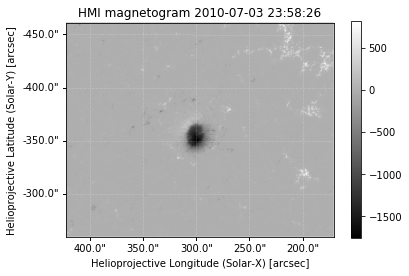

In [410]:
test_map = sunpy.map.Map('HMIdataset/fragments/HMI.2010-07-04_000000.AR11084.fits')
test_map.peek()
sunspots.loc['2010-07-04':'2013-01-01'].head()